**기본 세팅**

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

# 1. 로지스틱 회귀

로지스틱 회귀는 종속 변수가 이산형일 때 수행할 수 있는 회귀 분석 기법으로 오즈를 모델링 한 것이다.

종속 변수가 연속형이 아닌 이산형이고, 모델링 자체를 확률에 관해 진행하므로 로지스틱 회귀는 분류에 사용된다.

만약 독립변수가 하나라면 공식은 다음과 같다.

$$ \text{log} \dfrac{P(y=1)}{P(y=0)} = \text{log} \left( \dfrac{p}{1-p} \right) = \beta_{0} + \beta_{1}x$$

이 식을 정리하여 확률에 대해 나타내면 다음과 같다.

$$ P(y=1) = p = \dfrac{1}{1+e^{-\beta_{0} - \beta_{1}x}}$$

위 식에서 $\dfrac{1}{1+e^{-x}}$ 형태의 함수식을 시그모이드 함수라고 한다.

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 위스콘신 유방암 데이터
cancer = load_breast_cancer()

# StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

# train, test
X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

**로지스틱 학습/예측/평가**

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

lr_pred = lr_clf.predict(X_test)
lr_proba = lr_clf.predict_proba(X_test)[:,1].reshape(-1,1)

accuracy = accuracy_score(y_test, lr_pred)
auc = roc_auc_score(y_test, lr_proba)

print(f"accuracy: {accuracy:.4f}")
print(f"auc: {auc:.4f}")

accuracy: 0.9766
auc: 0.9947


**로지스틱 하이퍼 파라미터**

- `penalty`: L1규제와 L2규제를 설정하며 디폴트는 `l2`이다.


- `C`: 규제 강도를 조절하는 alpha값의 역수로 C값이 작을수록(alpha가 클수록) 규제 강도가 크다.

In [5]:
from sklearn.model_selection import GridSearchCV

params = {
    "penalty": ["l2", "l1"], 
    "C": [0.01, 0.1, 1, 5, 10]
}

lr_clf = LogisticRegression()
grid_cv = GridSearchCV(lr_clf, param_grid = params, scoring="accuracy", cv=3)
grid_cv.fit(cancer.data, cancer.target)

print("최적 하이퍼 파라미터:", grid_cv.best_params_)
print("최적 평균 정확도:", round(grid_cv.best_score_, 4))

최적 하이퍼 파라미터: {'C': 1, 'penalty': 'l2'}
최적 평균 정확도: 0.949


# 2. 회귀 트리

회귀 트리는 4장 분류에서 사용하였던 결정 트리와 크게 다르지 않다.

다만 리프 노드에서 예측 결정 값을 만드는 과정이 차이가 있는데, 결정 트리는 특정 클래스 레이블을 결정한다.

반면에 회귀 트리는 리프 노드에 속한 데이터의 평균값을 구해 회귀 예측값을 계산한다.

또한 결정 트리는 각 영역의 지니계수가 낮은 피처를 기준으로 분할하며 회귀 트리는 RSS를 가장 잘 줄일 수 있는 피처를 기준으로 분할한다.

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score

# 보스턴 데이터
boston = load_boston()
boston_df = pd.DataFrame(boston.data, columns = boston.feature_names)

boston_df['PRICE'] = boston.target
y_target = boston_df['PRICE']
X_data = boston_df.drop(['PRICE'], axis=1,inplace=False)

# RandomForestRegressor
rf = RandomForestRegressor(random_state=0, n_estimators=1000)

neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(f'5 교차 검증의 개별 Negative MSE scores: {np.round(neg_mse_scores, 2)}')
print(f'5 교차 검증의 개별 RMSE scores: {np.round(rmse_scores, 2)}')
print(f'5 교차 검증의 평균 RMSE : {avg_rmse:.3f}')

5 교차 검증의 개별 Negative MSE scores: [ -7.88 -13.14 -20.57 -46.23 -18.88]
5 교차 검증의 개별 RMSE scores: [2.81 3.63 4.54 6.8  4.34]
5 교차 검증의 평균 RMSE : 4.423


- 랜덤 포레스트 회귀 트리를 이용해 보스턴 주택 가격 예측 성능 RMSE를 구하였다.


- 랜덤 포레스트 외에도 XGB, LGBM 등 분류에서 사용한 알고리즘은 회귀 트리로 사용 가능하다.

**회귀 트리 성능 함수**

In [7]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    
    print(f'##### {model.__class__.__name__} #####')
    print(f'5 교차 검증의 평균 RMSE : {avg_rmse:.3f}')

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 회귀 트리 모델
dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgbm_reg = LGBMRegressor(n_estimators=1000)

# 성능 평가
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgbm_reg]

for model in models:
    get_model_cv_prediction(model, X_data, y_target)

##### DecisionTreeRegressor #####
5 교차 검증의 평균 RMSE : 5.978
##### RandomForestRegressor #####
5 교차 검증의 평균 RMSE : 4.423
##### GradientBoostingRegressor #####
5 교차 검증의 평균 RMSE : 4.269
##### XGBRegressor #####
5 교차 검증의 평균 RMSE : 4.251
##### LGBMRegressor #####
5 교차 검증의 평균 RMSE : 4.646


**피처별 중요도**

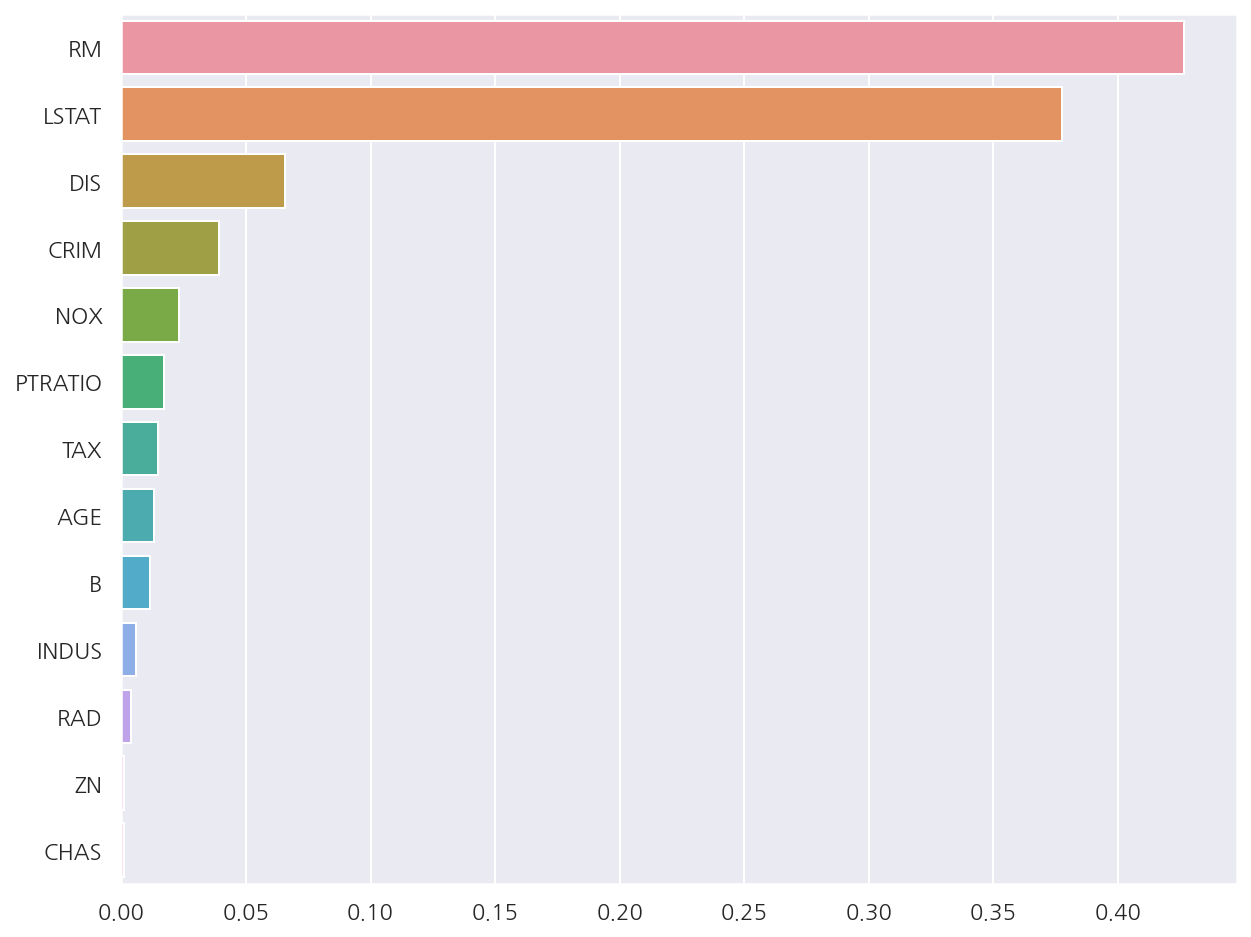

In [9]:
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns )
feature_series = feature_series.sort_values(ascending=False)

sns.barplot(x= feature_series, y=feature_series.index)
plt.show()

- 회귀 트리는 `coef_` 속성이 없고 대신 피처별 중요도는 확인 가능하다.

# 3. 선형 회귀와 회귀 트리

In [10]:
from sklearn.linear_model import LinearRegression

# boston sample: 100, feature: RM
boston_df_sample = boston_df[['RM','PRICE']].sample(n=100,random_state=0)
X_feature = np.array(boston_df_sample.RM).reshape(-1,1)
y_target = np.array(boston_df_sample.PRICE).reshape(-1,1)

# test data: 4.5 ~ 8.5 , 100개의 데이터
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1,1)

# 모델 객체 생성
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 학습/예측
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

lr_pred = lr_reg.predict(X_test)
rf_reg2_pred = rf_reg2.predict(X_test)
rf_reg7_pred = rf_reg7.predict(X_test)

- 선형 회귀와 회귀 트리의 예측값 판단이 어떻게 다른지 확인하기 위해 RM 피처 하나만을 이용해 시각화 해보도록 한다.


- 100개의 샘플을 이용해서 선형 회귀와 max_depth가 각각 2,7인 결정 트리 기반 회귀 트리 모델을 생성하였다.

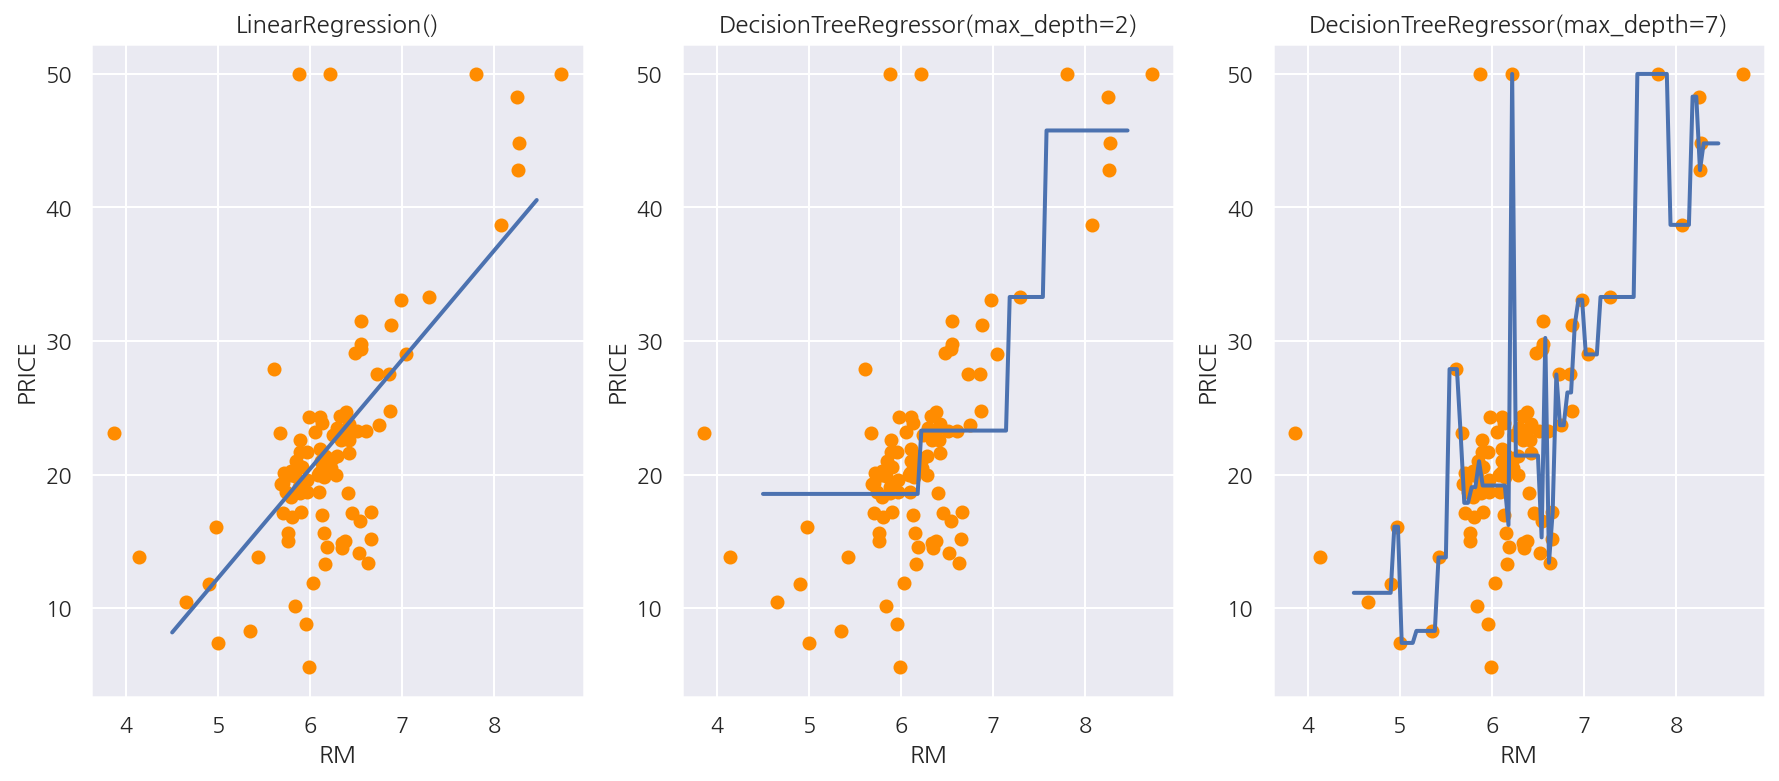

In [11]:
fig, axs = plt.subplots(1,3, figsize=(15,6))

models = [lr_reg, rf_reg2, rf_reg7]

for i, model in enumerate(models):
    pred = model.predict(X_test)
    
    axs[i].scatter(X_feature , y_target, c="darkorange")
    axs[i].plot(X_test, pred, lw=2)
    
    axs[i].set_title(model)
    axs[i].set_xlabel("RM")
    axs[i].set_ylabel("PRICE")
    
plt.show()

- 선형 회귀는 직선으로 회귀선을 만들고 회귀 트리는 분할되는 데이터 지점에 따라 브랜치를 만들면서 계단 형태로 회귀선을 만든다.


- 회귀 트리끼리 비교해선 max_depth가 7인 경우 train 데이터에 과적합 하여 예측 곡선이 복잡한 형태로 나타났다.


- 결정 트리와 거의 비슷하나 종속 변수(레이블 변수)를 연속형을 사용해서 분기 기준과 리프노드 예측값이 다르다는 것을 기억하자.